<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99' # NOTE: jax preallocates GPU (default 75%)
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap

dphppce115.extra.cea.fr
cpu


## Categorical sampling

In [2]:
n = 100
p = jnp.abs(jr.normal(jr.key(0), (n,)))
p /= jnp.sum(p)
m = 1000

import time
ns = jnp.logspace(2, 9, 10, base=10, dtype=int)
ms = jnp.logspace(2, 9, 20, base=10, dtype=int)
ps = []
for n in ns:
    p = jnp.abs(jr.normal(jr.key(0), (n,)))
    p /= jnp.sum(p)
    # p = np.abs(np.random.normal(size=(n,)))
    # p /= np.sum(p)
    ps.append(p)

2024-07-23 22:39:54.871695: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:2670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:2671: UserWarning: Explicitly re

In [3]:
execution_times = []
for n, p in zip(ns, ps):
# for shape in shapes:
    print(n)
    start_time = time.time()    
    for _ in range(10):
        # res = np.random.choice(np.broadcast_to(n, p.shape), (m,), p=p)
        res = jr.choice(jr.key(1), n, shape=(m,), p=p)
    end_time = time.time()

    execution_time = end_time - start_time
    execution_times.append(execution_time)

99
599
3593
21544
129154
774263
4641587
27825608
166810080
999999936


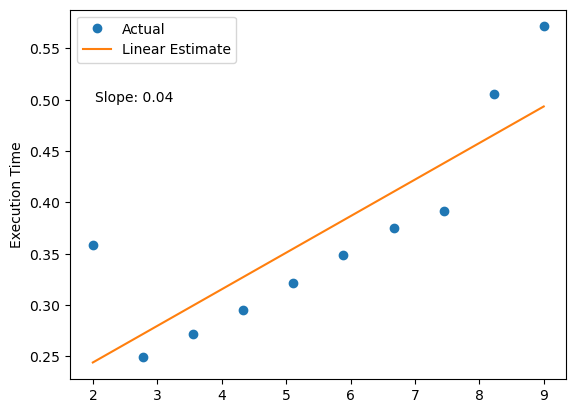

R-squared: 0.6878867612949101


In [5]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Convert shapes and times to numpy arrays
xs = np.log10(ns)
times = np.array(execution_times)

plot_fn = plt.plot
# Create a linear regression model
model = LinearRegression()
xs = xs.reshape(-1, 1)
model.fit(xs, times)
r_squared = model.score(xs, times)
predicted_times = model.predict(xs)

# Plot the data and the linear estimate
slope = model.coef_[0]
plot_fn(xs, times, 'o', label='Actual')
plot_fn(xs, predicted_times, label='Linear Estimate')
plt.ylabel('Execution Time')
plt.legend()
plt.text(0.05, 0.75, f'Slope: {slope:.2f}', transform=plt.gca().transAxes)
plt.show()
print(f'R-squared: {r_squared}')

* uniform sampling like `np.choice(p=None)` is done in $O(m)$.
* [categorical sampling](https://www.keithschwarz.com/darts-dice-coins/) like `np.choice(p=p)` is done in $O(n+m\log n)$ steps, where $n$ is number of categories. See also [SOF](https://stackoverflow.com/questions/40143157/big-o-complexity-of-random-choicelist-in-python3) and [numpy](https://github.com/numpy/numpy/blob/2eedaa4cf94cf54bbd4d8428aa39271410f22e9f/numpy/random/mtrand.pyx#L936)

## KDE

In [7]:
import time
import numpy as np
from sklearn.neighbors import KernelDensity

execution_times = []
d = 3
scale = 1
ns = [10000]  # Example values for n
ms = [100]  # Example values for m
ns = np.logspace(3, 6.5, 20, base=10, dtype=int)
# ms = np.logspace(2, 7.5, 10, base=10, dtype=int)

i_count = 0
for n in ns:
    for m in ms:
        samples = scale * np.random.normal(0, 1, (n, d))
        # samples1 = scale * np.random.multivariate_normal(2*np.array([1,1]), [[1.5,1],[1,1.5]], (n))/2
        # samples2 = scale * np.random.multivariate_normal(2*np.array([-1,-1]), [[1.5,1],[1,1.5]], (n))/2
        # samples = np.concatenate([samples1, samples2], axis=0)
        # samples = scale * np.random.uniform(-1, 1, (n, d))
        other_points = scale * np.random.uniform(-1, 1, (m, d))

        scott = samples.shape[0] ** (-1 / (samples.shape[1] + 4))
        kde = KernelDensity(kernel='epanechnikov', bandwidth=2*scott)
        # kde = KernelDensity(kernel='gaussian', bandwidth=scott, atol=1e-5, rtol=1e-5)
        
        kde.fit(samples)
        logp_fn = lambda x: kde.score_samples(x)
        start_time = time.time()
        # log_densities = logp_fn(samples)
        log_densities = logp_fn(other_points)
        end_time = time.time()

        execution_time = end_time - start_time
        execution_times.append(execution_time)
        i_count += 1
        print(f"For {n=} and {m=}, time: {execution_time:.5f} seconds, i={i_count}")

For n=1000 and m=100, time: 0.00515 seconds, i=1
For n=1528 and m=100, time: 0.00626 seconds, i=2
For n=2335 and m=100, time: 0.00709 seconds, i=3
For n=3569 and m=100, time: 0.00819 seconds, i=4
For n=5455 and m=100, time: 0.00858 seconds, i=5
For n=8337 and m=100, time: 0.01050 seconds, i=6
For n=12742 and m=100, time: 0.01241 seconds, i=7
For n=19474 and m=100, time: 0.01503 seconds, i=8
For n=29763 and m=100, time: 0.01865 seconds, i=9
For n=45487 and m=100, time: 0.02290 seconds, i=10
For n=69519 and m=100, time: 0.02785 seconds, i=11
For n=106246 and m=100, time: 0.03434 seconds, i=12
For n=162377 and m=100, time: 0.03976 seconds, i=13
For n=248162 and m=100, time: 0.04722 seconds, i=14
For n=379269 and m=100, time: 0.05907 seconds, i=15
For n=579639 and m=100, time: 0.07170 seconds, i=16
For n=885866 and m=100, time: 0.05800 seconds, i=17
For n=1353876 and m=100, time: 0.09506 seconds, i=18
For n=2069138 and m=100, time: 0.13329 seconds, i=19
For n=3162277 and m=100, time: 0.197

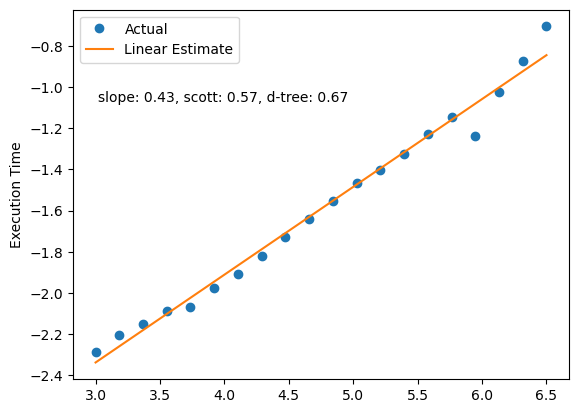

R-squared: 0.9855604784115413


In [8]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Convert shapes and times to numpy arrays
xs = np.array(ns)
# xs = np.array(ms)
# times = np.array(execution_times)
# times = np.array(execution_times) / np.log(xs)
xs = np.log10(ns)
# xs = np.log(ms)
times = np.log10(execution_times )

plot_fn = plt.plot
# Create a linear regression model
model = LinearRegression()
xs = xs.reshape(-1, 1)
model.fit(xs, times)
r_squared = model.score(xs, times)
predicted_times = model.predict(xs)

# Plot the data and the linear estimate
slope = model.coef_[0]
plot_fn(xs, times, 'o', label='Actual')
plot_fn(xs, predicted_times, label='Linear Estimate')
plt.ylabel('Execution Time'), plt.legend()
plt.text(0.05, 0.75, f'slope: {slope:.2f}, scott: {1-d/(d+4):.2f}, d-tree: {1-1/d:.2f}', transform=plt.gca().transAxes)
plt.show()
print(f'R-squared: {r_squared}')

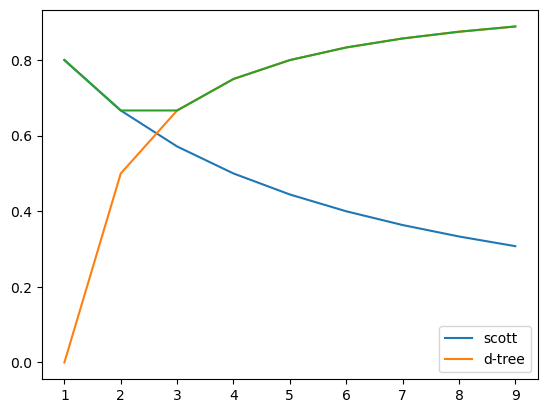

In [28]:
k_fn = lambda d : (1-d/(d+4))
q_fn = lambda d : (1-1/d)
qk_fn = lambda d : np.maximum(k_fn(d), q_fn(d))
ds = np.arange(1, 10)
plt.plot(ds, k_fn(ds), label='scott')
plt.plot(ds, q_fn(ds), label='d-tree')
plt.plot(ds, qk_fn(ds))
plt.legend();

* KDE complexity for $n$ sources, $m$ target, $d$ dimensions, is at most $O(nmd)$ (Naive). 
* Some technics can reduce it to $O(n+m\log m)$ (FFT-based), or $O(dn\log n + m n^{1-\min(\frac{1}{d},\frac{d}{d+4})})$ (Tree-based). 

## KDE

In [81]:
from montecosmo.kde import GaussianMixture, KDE_bw, KDE_kNN

n, m, d = 10000, 10, 2
scale = 1
# loc = np.zeros(d)
# cov = np.eye(d)
loc = np.array([1,0])
cov = np.array([[1.5,1],[1,1.5]])/3
mixture_conf = {
    'weights': [1,1.3,1.3],
    'means': np.array([loc,-loc,2-loc]),
    'covs': np.array([cov,cov,cov])
    # 'weights': [1],
    # 'means': np.array([loc]),
    # 'covs': np.array([cov]),
}

# Generate samples from the mixture distribution
mixture_dist = GaussianMixture(**mixture_conf)
samples = mixture_dist.rvs(size=n, random_state=0)
logp_true = mixture_dist.logpdf

In [82]:
# logp_fn = KDE_bw(samples, bandwidth='kNN')
# logp_fn = KDE_bw(samples, bandwidth='cvml')
logp_fn = KDE_bw(samples, bandwidth='scott')
# logp_fn = KDE_kNN(samples)

0.2154434690031884 0.2154434690031884


0.9731882525640009


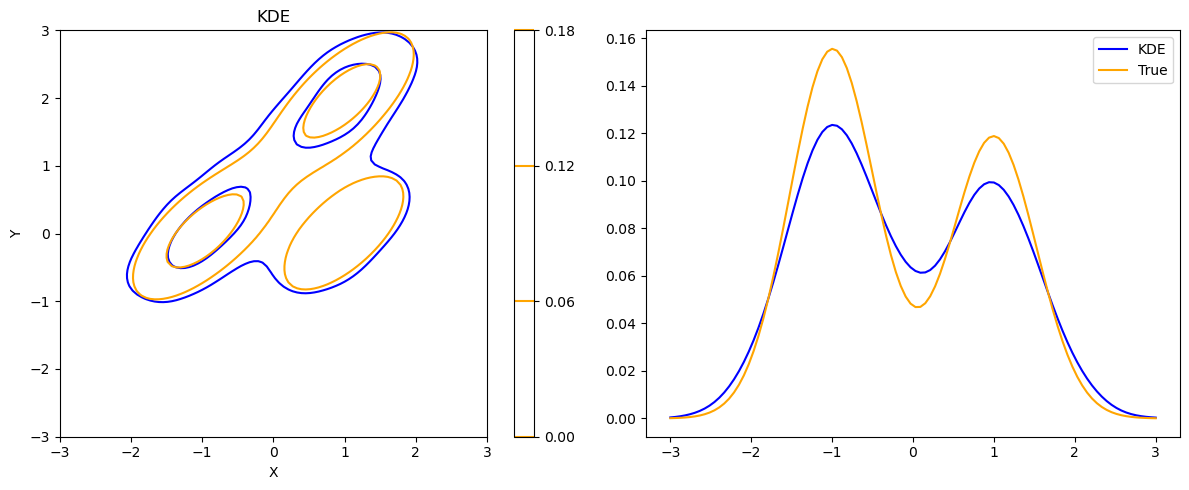

In [84]:
# Create a meshgrid
lim = 3
levels = 2
x = scale * np.linspace(-lim, lim, 100)
y = scale * np.linspace(-lim, lim, 101)
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T

if d == 1:
    probs = np.exp(logp_fn(x[:,None]))
    probs_true = np.exp(logp_true(x[:,None]))
    volume = x.max() - x.min()
    print(probs.mean() * volume)
    plt.hist(samples, bins=20, density=True)
    plt.plot(x, probs, label="KDE")
    plt.plot(x, probs_true, label="True")
    plt.legend()

elif d == 2:
    mesh = np.exp(logp_fn(positions)).reshape(X.shape)
    mesh_true = np.exp(logp_true(positions)).reshape(X.shape)

    # Plot the density using pcolormesh
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    # plt.pcolormesh(X, Y, mesh, shading='auto')
    plt.contour(X, Y, mesh, levels=levels, colors='blue')
    plt.contour(X, Y, mesh_true, levels=levels, colors='orange')
    volume = (X.max() - X.min()) * (Y.max() - Y.min())
    print(Z.mean() * volume)
    plt.colorbar()
    plt.xlabel('X'), plt.ylabel('Y'), plt.title('KDE')
    plt.subplot(122)
    proj = np.stack([x, np.broadcast_to(y.mean(), x.shape)], axis=-1)
    probs = np.exp(logp_fn(proj))
    probs_true = np.exp(logp_true(proj))
    plt.plot(x, probs, label="KDE", color='b')
    plt.plot(x, probs_true, label="True", color='orange')
    plt.legend()
    plt.tight_layout(), plt.show();